### This notebook demonstrates how to compute the over-represented words in a corpus of text.

It works by counting word frequencies in the designated dataset (in this case a large set of LLM-generated creative writing). These frequencies are compared that against the wordfreq frequencies, which represent the average prevalence of words in (human) language.

In [1]:
#!pip3 install wordfreq datasets numpy

In [15]:
from collections import Counter
from wordfreq import word_frequency
import numpy as np
import re
from tqdm import tqdm
from src.slop_index import load_and_preprocess_slop_words, calculate_slop_index

def parse_text(my_corpus):
    # If the corpus is a single string, split it into a list of texts (in this case, just one text)
    if isinstance(my_corpus, str):
        texts = [my_corpus]
    elif isinstance(my_corpus, list):
        texts = my_corpus
    else:
        raise ValueError("The corpus should be a string or a list of strings.")
    
    return texts

def get_word_counts(texts, min_length=4):
    """
    Count word frequencies in a list of texts.

    Parameters:
    - texts (iterable of str): The input texts to process.
    - min_length (int): Minimum length of words to include.

    Returns:
    - Counter: A Counter object mapping words to their frequencies.
    """
    # Precompile the regex pattern for better performance
    # This pattern matches words with internal apostrophes (e.g., "couldn't")
    pattern = re.compile(r"\b\w+(?:'\w+)?\b")
    
    word_counts = Counter()
    
    for text in tqdm(texts, desc="Counting words"):
        if not isinstance(text, str):
            continue  # Skip non-string entries to make the function more robust
        
        # Convert to lowercase and find all matching words
        words = pattern.findall(text.lower())
        
        # Update counts with words that meet the minimum length
        word_counts.update(word for word in words if len(word) >= min_length)
    
    return word_counts

def analyze_word_rarity(word_counts):
    total_words = sum(word_counts.values())
    corpus_frequencies = {word: count / total_words for word, count in word_counts.items()}
    
    wordfreq_frequencies = {word: word_frequency(word, 'en') for word in word_counts.keys()}
    
    # Filter out words with zero frequency
    valid_words = [word for word, freq in wordfreq_frequencies.items() if freq > 0]
    
    corpus_freq_list = [corpus_frequencies[word] for word in valid_words]
    wordfreq_freq_list = [wordfreq_frequencies[word] for word in valid_words]
    
    # Calculate average rarity
    avg_corpus_rarity = np.mean([-np.log10(freq) for freq in corpus_freq_list])
    avg_wordfreq_rarity = np.mean([-np.log10(freq) for freq in wordfreq_freq_list])
    
    # Calculate correlation
    correlation = np.corrcoef(corpus_freq_list, wordfreq_freq_list)[0, 1]
    
    return corpus_frequencies, wordfreq_frequencies, avg_corpus_rarity, avg_wordfreq_rarity, correlation

def filter_mostly_numeric(word_counts):
    def is_mostly_numbers(word):
        digit_count = sum(c.isdigit() for c in word)
        return digit_count / len(word) > 0.2  # Adjust this ratio if needed
    return Counter({word: count for word, count in word_counts.items() if not is_mostly_numbers(word)})


def find_over_represented_words(corpus_frequencies, wordfreq_frequencies, top_n=50000):
    over_representation = {}
    for word in corpus_frequencies.keys():
        wordfreq_freq = wordfreq_frequencies[word]
        if wordfreq_freq > 0:  # Only consider words with non-zero frequency
            over_representation[word] = corpus_frequencies[word] / wordfreq_freq
    
    return sorted(over_representation.items(), key=lambda x: x[1], reverse=True)[:top_n]

def find_zero_frequency_words(word_counts, wordfreq_frequencies, top_n=50000):
    zero_freq_words = {word: count for word, count in word_counts.items() if wordfreq_frequencies[word] == 0}
    return sorted(zero_freq_words.items(), key=lambda x: x[1], reverse=True)[:top_n]

# Load slop words for analysis
slop_words = load_and_preprocess_slop_words()

# Example usage:
my_corpus = """
Life often throws unexpected challenges our way, and how we respond can either shape our success or leave us struggling. What gives someone the strength to rebuild after a catastrophe? Charles Krauthammer, in his essay "Rick Ankiel: The Return of the Natural," tells the story of Rick Ankiel, a talented baseball player, who faced devastating setbacks yet fought his way back to another grasp at glory. Krauthammer, the writer himself, embodies this same resilience. After a diving accident left him paralyzed from the neck down, he rebuilt his life, transitioning from a career in medicine to becoming a Pulitzer Prize-winning political commentator. Similarly, Susan Snyder’s article, "Injury and Financial Hardship Couldn't Keep These La Salle Graduates from Earning a Degree," highlights individuals like Matthew Cruz, who persevered through paralysis to graduate college
"""

texts = parse_text(my_corpus)
word_counts = get_word_counts(texts)
corpus_frequencies, wordfreq_frequencies, avg_corpus_rarity, avg_wordfreq_rarity, correlation = analyze_word_rarity(word_counts)

print(f"Average corpus rarity: {avg_corpus_rarity}")
print(f"Average word frequency rarity: {avg_wordfreq_rarity}")
print(f"Correlation between corpus and word frequency: {correlation}")

def filter_mostly_numeric(word_counts):
    def is_mostly_numbers(word):
        digit_count = sum(c.isdigit() for c in word)
        return digit_count / len(word) > 0.2  # Adjust this ratio if needed
    
    # Create a new Counter with filtered words
    return Counter({word: count for word, count in word_counts.items() if not is_mostly_numbers(word)})

filtered_counts = filter_mostly_numeric(word_counts)

# Calculate slop index for each text block
print("\nCalculating slop index for each text:")
slop_scores = []
for text in texts:
    slop_score = calculate_slop_index(text)
    slop_scores.append(slop_score)
    print(f"Slop Index for the text block: {slop_score:.4f}")

# Analyzing slop phrases specifically
print("\nAnalyzing slop phrases in the text:")
slop_phrase_counts = Counter()
for text in texts:
    for slop_word, score in slop_words.items():
        if re.search(r'\b' + re.escape(slop_word) + r'\b', text.lower()):
            slop_phrase_counts[slop_word] += 1

print("\nMost frequent slop phrases in the corpus:")
for word, count in slop_phrase_counts.most_common(10):  # Limit output for brevity
    print(f"{word}: {count} occurrences")
                
# Example Output
print("\nSlop Scores for each block of text:")
for i, score in enumerate(slop_scores, start=1):
    print(f"Text Block {i}: Slop Index = {score:.4f}")
     
print("Analyzing word rarity...")
corpus_frequencies, wordfreq_frequencies, avg_corpus_rarity, avg_wordfreq_rarity, correlation = analyze_word_rarity(filtered_counts)

print(f"Total unique words analyzed: {len(word_counts)}")
print(f"Average corpus rarity: {avg_corpus_rarity:.4f}")
print(f"Average wordfreq rarity: {avg_wordfreq_rarity:.4f}")
print(f"Correlation between corpus and wordfreq frequencies: {correlation:.4f}")

print("\nMost over-represented words in the corpus:")
over_represented = find_over_represented_words(corpus_frequencies, wordfreq_frequencies)
for word, score in over_represented:
    print(f"{word}: {score:.2f} times more frequent than expected")

print("\nMost frequent words with zero wordfreq frequency:")
zero_freq_words = find_zero_frequency_words(filtered_counts, wordfreq_frequencies)
for word, count in zero_freq_words:
    print(f"{word}: {count} occurrences")


Counting words: 100%|██████████| 1/1 [00:00<?, ?it/s]

Average corpus rarity: 1.9404669893097957
Average word frequency rarity: 4.368578902872114
Correlation between corpus and word frequency: 0.3360315607746648

Calculating slop index for each text:
Slop Index for the text block: 30.5257

Analyzing slop phrases in the text:

Most frequent slop phrases in the corpus:
diving: 1 occurrences
resilience: 1 occurrences
persevered: 1 occurrences
unexpected: 1 occurrences
setbacks: 1 occurrences

Slop Scores for each block of text:
Text Block 1: Slop Index = 30.5257
Analyzing word rarity...
Total unique words analyzed: 85
Average corpus rarity: 1.9405
Average wordfreq rarity: 4.3686
Correlation between corpus and wordfreq frequencies: 0.3360

Most over-represented words in the corpus:
ankiel: 929022.67 times more frequent than expected
krauthammer: 99265.44 times more frequent than expected
persevered: 25455.66 times more frequent than expected
salle: 7344.30 times more frequent than expected
embodies: 7012.62 times more frequent than expected
se

Counting words: 100%|██████████| 1/1 [00:00<?, ?it/s]

Insufficient variability in data for calculating correlation. Correlation set to NaN.


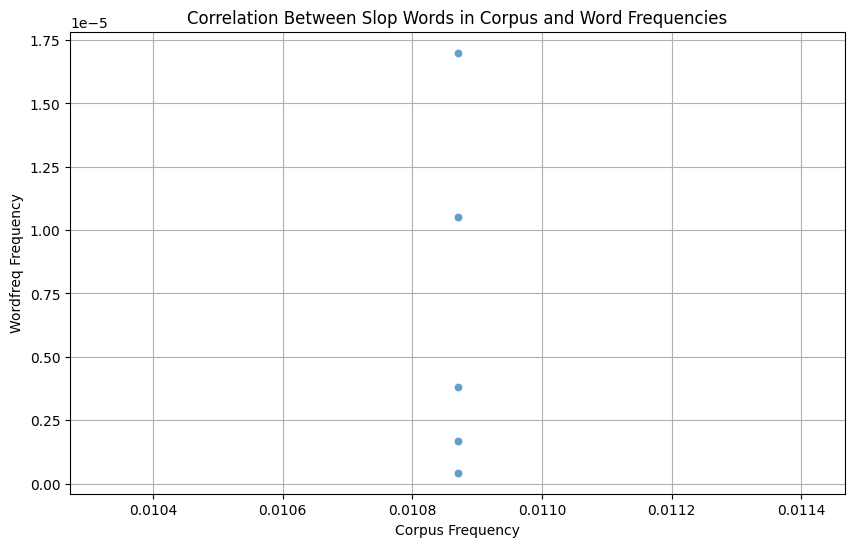

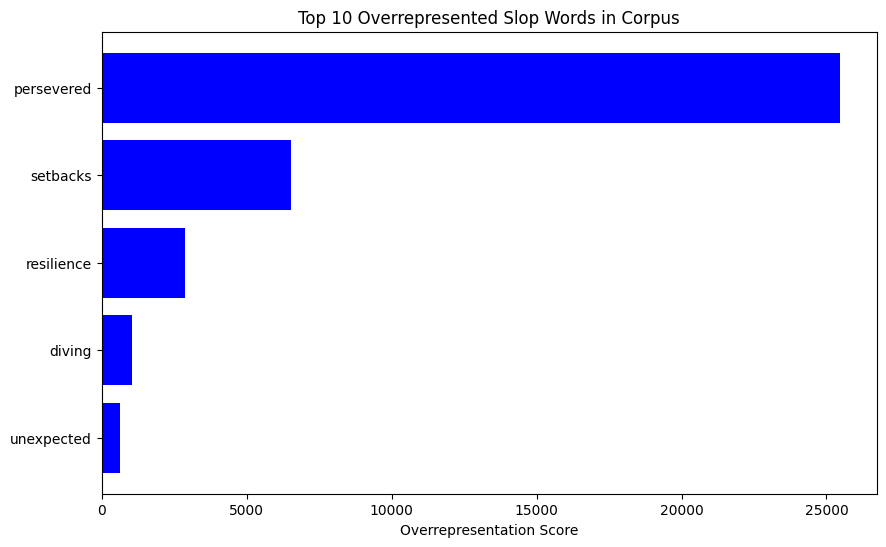

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from src.slop_index import load_and_preprocess_slop_words
from wordfreq import word_frequency

# Step 1: Load the slop words
slop_words = load_and_preprocess_slop_words()

# Step 2: Parse and count word occurrences in the corpus
texts = parse_text(my_corpus)
word_counts = get_word_counts(texts)

# Step 3: Filter the corpus to focus on words present in the slop phrases
slop_word_counts = Counter({word: count for word, count in word_counts.items() if word in slop_words})

# Step 4: Correlation Analysis
slop_word_freqs = {word: word_frequency(word, 'en') for word in slop_word_counts.keys()}
slop_corpus_frequencies = {word: count / sum(word_counts.values()) for word, count in slop_word_counts.items()}

# Check if valid_words has enough data points to calculate correlation
if len(valid_words) > 1:
    x = [slop_corpus_frequencies[word] for word in valid_words]
    y = [slop_word_freqs[word] for word in valid_words]
    
    # Calculate correlation if there is enough variability
    if np.std(x) > 0 and np.std(y) > 0:
        correlation = np.corrcoef(x, y)[0, 1]
        print(f"Correlation between slop words in the corpus and word frequency data: {correlation:.4f}")
    else:
        print("Insufficient variability in data for calculating correlation. Correlation set to NaN.")
        correlation = float('nan')
else:
    print("Not enough valid data points to calculate correlation. Correlation set to NaN.")
    correlation = float('nan')

# Step 5: Plotting the correlation
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.7, edgecolors='w', linewidth=0.5)
plt.title('Correlation Between Slop Words in Corpus and Word Frequencies')
plt.xlabel('Corpus Frequency')
plt.ylabel('Wordfreq Frequency')
plt.grid(True)
plt.show()

# Step 6: Visualizing Overrepresented Slop Words
over_representation = {word: slop_corpus_frequencies[word] / slop_word_freqs[word]
                       for word in valid_words if slop_word_freqs[word] > 0}
sorted_over_rep = sorted(over_representation.items(), key=lambda x: x[1], reverse=True)

# Plot the top 10 overrepresented slop words
top_words, top_scores = zip(*sorted_over_rep[:10])
plt.figure(figsize=(10, 6))
plt.barh(top_words, top_scores, color='blue')
plt.xlabel('Overrepresentation Score')
plt.title('Top 10 Overrepresented Slop Words in Corpus')
plt.gca().invert_yaxis()
plt.show()
